# Trains a model to detect a diffusion generated image using the Synthbuster and RAISE Dataset

Converts this Notebook to a regular Python Script for better debugging.

In [22]:
!jupyter nbconvert --to script training.ipynb

7909.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[NbConvertApp] Converting notebook training.ipynb to script
[NbConvertApp] Writing 10123 bytes to training.py


## Training
Import the FastAI library and set up utils.

In [1]:
from fastcore.all import *
from fastai.vision.all import *

run = 21
path = Path('data/training/')
def get_balanced_items(path):
    fake_images = get_image_files(path/'train/fake') + get_image_files(path/'valid/fake')
    real_images = get_image_files(path/'train/real') + get_image_files(path/'valid/real')
    min_count = min(len(fake_images), len(real_images))
    return random.sample(fake_images, min_count) + random.sample(real_images, min_count)

def get_y(path):
    """Custom labeler to categorize images into 'fake' or 'real'."""
    if 'fake' in path.parts:
        return 'fake'
    elif 'real' in path.parts:
        return 'real'
    else:
        raise ValueError(f"Path to image ({str(path)}) contains neither a 'fake' or a 'real' folder")

# Create models folder if it doesn't exist
models_path = Path(f'models/run{run}')
models_path.mkdir(exist_ok=True)

class SaveModelCallbackWithEpoch(SaveModelCallback):
    def __init__(self, monitor='valid_loss', fname='model', with_opt=False, at_end=False, every_epoch=False):
        super().__init__(monitor=monitor, fname=fname, with_opt=with_opt, at_end=at_end, every_epoch=every_epoch)
        self.original_fname = fname

    def _save(self, name):
        # epoch = self.epoch + 1  # Add 1 because epoch is 0-indexed
        filename = f"{self.original_fname}_epoch_{self.epoch}"
        super()._save(filename)

    def after_epoch(self):
        if self.every_epoch:
            self._save(f"{self.original_fname}")
        else:
            current = self.get_monitor_value()
            if current is not None and (self.best is None or current < self.best):
                self.best = current
                self._save(f"{self.original_fname}_best")
            if self.at_end:
                self._save(f"{self.original_fname}")

def train_model(learn, fname='model_checkpoint', epochs=4, start_epoch=0):
    learn.add_cb(MixUp())
    
    # Add callbacks for early stopping and saving model
    early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=4)
    reduce_lr = ReduceLROnPlateau(monitor='valid_loss', patience=2, min_delta=0.001)
    save_model = SaveModelCallbackWithEpoch(monitor='valid_loss', fname=fname, with_opt=True, every_epoch=True)
    
    # Find learning rate
    lr = learn.lr_find()
    print(f"Suggested learning rates: {lr}")
    
    # Train the model
    learn.fine_tune(epochs, start_epoch=start_epoch, cbs=[save_model, reduce_lr, early_stop])
    
    return learn

Remove Images that failed downloading

In [3]:
path = Path('data/imagenet1kvalid/')
failed = verify_images(get_image_files(path))
# This would delete the images that could not be verified.
# But since we use established, working datasets, we need to solve the issues manually, and not just delete the images.
# failed.map(Path.unlink)
print(failed)
len(failed)

[]


0

### Resnet18
First, train a quick Resnet18 model for testing, since training is really fast. Resnet18 needs a image resolution of 192x192.

Create the dataloader. Since the datasets are divided into the ./data/fake and ./data/real folder, we can use the path to label the images.

Training set size: 136251
Validation set size: 28766


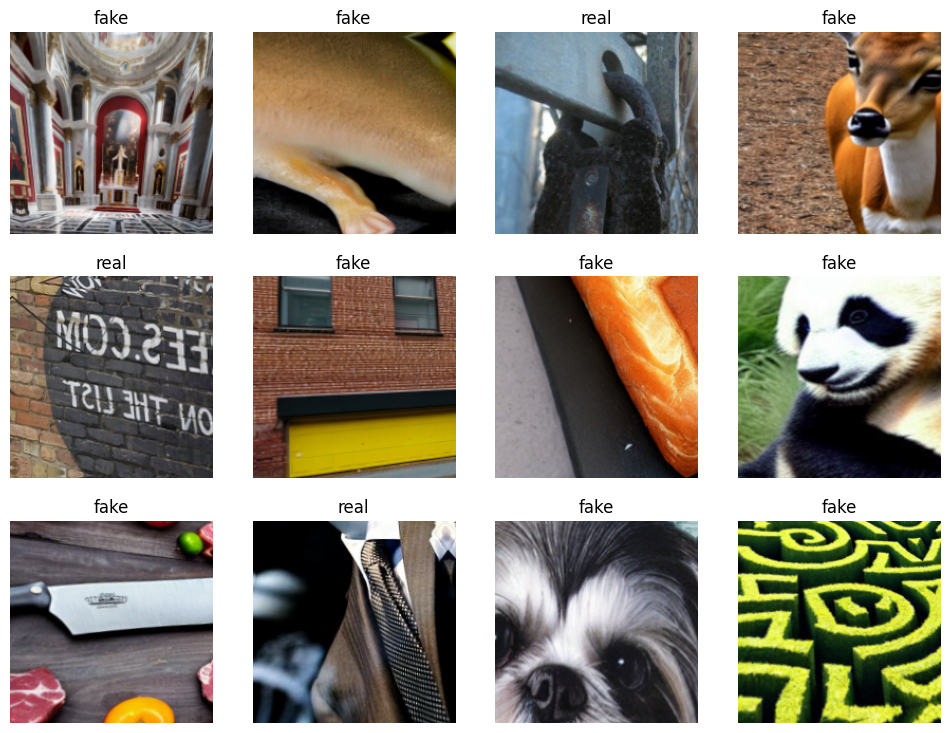

In [2]:
path = Path('data/training/')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=FuncSplitter(lambda o: 'valid' in Path(o).parts),
    get_y=get_y,
    item_tfms=[RandomResizedCrop(192)],
    batch_tfms=aug_transforms()
).dataloaders(path)

print(f"Training set size: {len(dls.train_ds)}")
print(f"Validation set size: {len(dls.valid_ds)}")

dls.show_batch(max_n=12)

#### Train the resnet model.

Even though the training is so quick the model gives acceptable results.

An epoch takes around 45 seconds to complete, and the error rate is at 0.0236

Suggested learning rates: SuggestedLRs(valley=0.0030199517495930195)


epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.474840,0.318291,0.134986,0.821216,0.909722,0.748406,01:07


epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.362285,0.207876,0.082563,0.904668,0.867046,0.945703,02:41
1,0.343151,0.188173,0.075123,0.914487,0.865219,0.969705,02:41
2,0.315355,0.140955,0.053987,0.936995,0.906935,0.969117,02:41
3,0.307755,0.142596,0.055135,0.935981,0.901695,0.972978,02:41


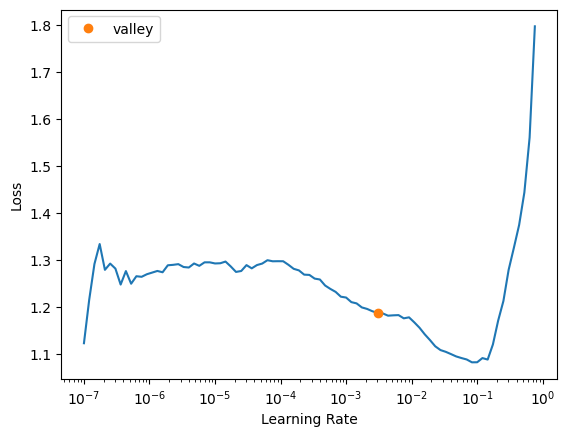

In [3]:
# Create the model
# fake_count = len(get_image_files(Path('data/training/train/fake/')))
# real_count = len(get_image_files(Path('data/training/train/real/')))
# class_weights = torch.Tensor([1.0, real_count / fake_count])
# loss_func = nn.CrossEntropyLoss(weight=class_weights)

# Initial training
learn = vision_learner(dls, resnet18, metrics=[error_rate, F1Score(), Precision(), Recall()])
learn = train_model(learn, fname='fastai_resnet18', epochs=4)

#### Resume training from checkpoint

In [12]:
checkpoint_to_load = 'run18/fastai_resnet18_epoch_3'  # Replace with the specific checkpoint you want to load
learn = vision_learner(dls, resnet18, metrics=[error_rate, F1Score(), Precision(), Recall()])
learn.load(checkpoint_to_load)
# learn = train_model(epochs=8, start_epoch=2)  # Adjust start_epoch based on the loaded checkpoint

### ConvNeXT
Now try the ConvNeXT architecture, as it should provide far better performance without huge training times.

Since ConvNeXT isn't part of FastAI, we use it with FastAIs TIMM integration.

First, we need to find out what the ConvNeXT models are called in TIMM exactly.

In [1]:
import timm
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

Then we create another dataloader. It is the same as the resnet18 loader, except that ConvNeXT needs a resolution of 224x224.

We also specify a batch size to speed up training. 64 still took a long time and seemed to need 11GB of VRAM.

Training set size: 136251
Validation set size: 28766


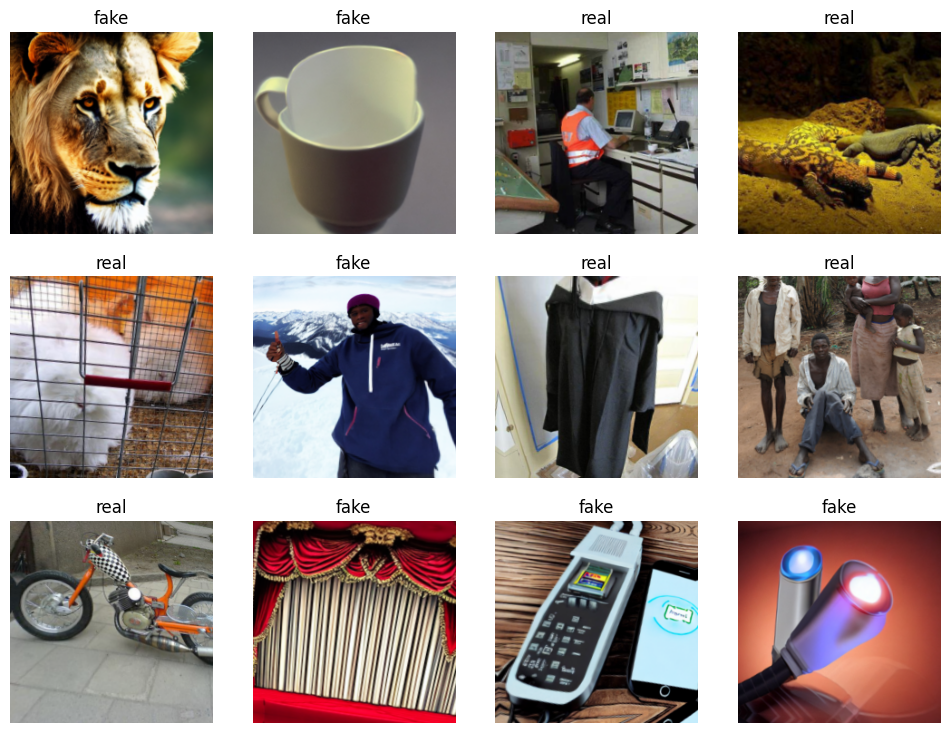

In [2]:
path = Path('data/training/')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=FuncSplitter(lambda o: 'valid' in Path(o).parts),
    get_y=get_y,
    item_tfms=[Resize(224, method=ResizeMethod.Crop)],
    batch_tfms=aug_transforms()
).dataloaders(path)

print(f"Training set size: {len(dls.train_ds)}")
print(f"Validation set size: {len(dls.valid_ds)}")

dls.show_batch(max_n=12)

#### Train the ConvNeXT model.
An Epoch takes around 5 minutes to complete.

In [ ]:
# Initial training
learn = vision_learner(dls, 'convnextv2_tiny', metrics=[error_rate, F1Score(), Precision(), Recall()])
learn = train_model(learn, fname='fastai_convnextv2_tiny', epochs=15)

Suggested learning rates: SuggestedLRs(valley=0.0014454397605732083)


epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.308428,0.115458,0.033964,0.960078,0.935574,0.985901,09:53


epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.264427,0.111057,0.041890,0.951744,0.910226,0.997231,13:32
1,0.237596,0.073378,0.027811,0.967445,0.939090,0.997566,13:32
2,0.238269,0.071278,0.026698,0.968717,0.941190,0.997902,13:31
3,0.226245,0.068626,0.026177,0.969344,0.941330,0.999077,13:33
4,0.218195,0.048393,0.018077,0.978618,0.959368,0.998657,13:34
5,0.207553,0.060050,0.021206,0.975020,0.952095,0.999077,13:34
6,0.207315,0.072953,0.027324,0.968049,0.938742,0.999245,13:36
7,0.207187,0.031392,0.010777,0.987147,0.975578,0.998993,13:40
8,0.203293,0.055423,0.017729,0.979033,0.959623,0.999245,13:33
9,0.201103,0.038748,0.012445,0.985191,0.971447,0.999329,13:33


Epoch 6: reducing lr to 8.6657509125309e-05
Epoch 9: reducing lr to 4.627104925140079e-05


#### Resume Training from Checkpoint

In [3]:
checkpoint_to_load = 'run21/fastai_convnextv2_tiny_epoch_9'  # Replace with the specific checkpoint you want to load
learn = vision_learner(dls, 'convnextv2_tiny', metrics=[error_rate, F1Score(), Precision(), Recall()])
learn.load(checkpoint_to_load)
# learn = train_model(epochs=8, start_epoch=2)  # Adjust start_epoch based on the loaded checkpoint

## Checking the model
### Metrics
Shows the confusion matrix and Precision, Recall, and F1 Scores.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. It answers the question, "Of all the images labeled as 'X' by the model, how many actually belong to 'X'?"
- **Recall (Sensitivity)**: The ratio of correctly predicted positive observations to all the observations in the actual class. It answers, "Of all the images that truly belong to 'X', how many did we correctly label as 'X'?"
- **F1-Score**: The weighted average of Precision and Recall. It takes both false positives and false negatives into account. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.
- **Support**: The number of actual occurrences of the class in the specified dataset.

              precision    recall  f1-score   support

        fake       1.00      0.98      0.99     16850
        real       0.97      1.00      0.99     11916

    accuracy                           0.99     28766
   macro avg       0.99      0.99      0.99     28766
weighted avg       0.99      0.99      0.99     28766



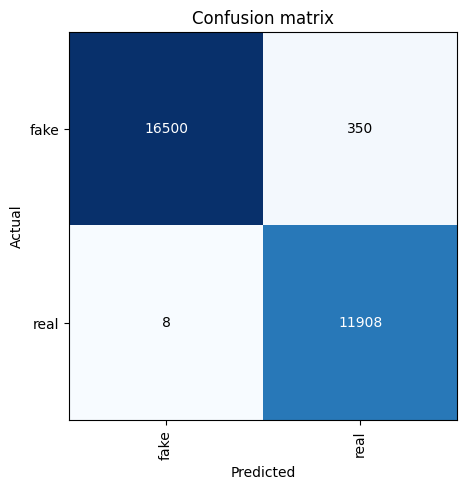

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.savefig(models_path/f'confusion_matrix_run_{run}.png', dpi=300, bbox_inches='tight')

# Precision, Recall, and F1 Scores
interp.print_classification_report()

#### Top Losses
Shows the images with the top losses for the validation data. This shows examples of where the model fails the hardest.

/home/code/.conda/envs/fastai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class Statistics:


Dataset Statistics:


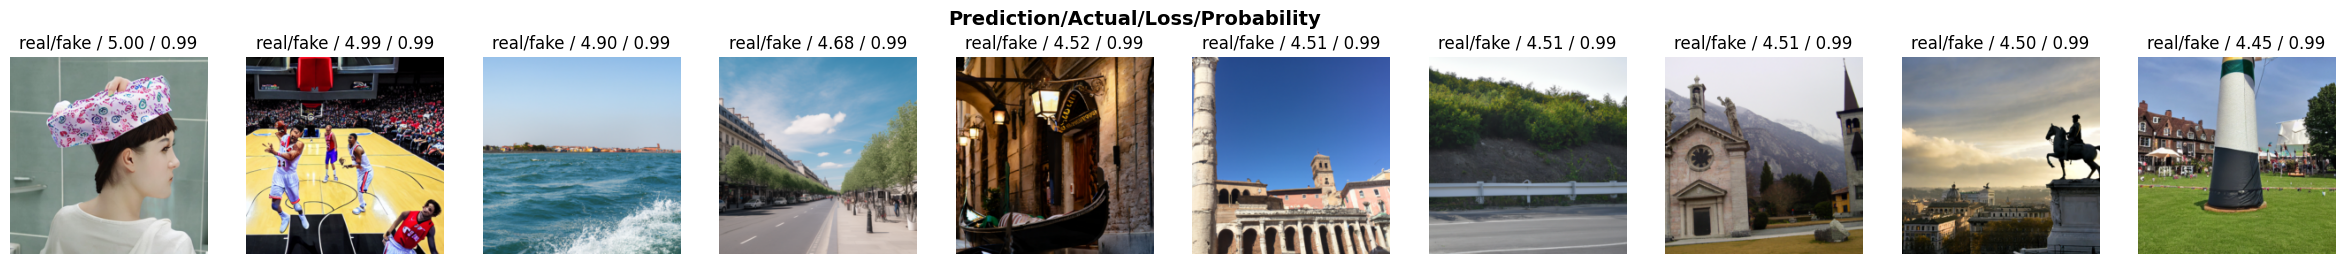

In [14]:
interp.plot_top_losses(k=10, nrows=1)

# Get the top losses
losses, _, items = interp.top_losses(k=300, items=True)

def extract_info(path):
    parts = path.parts
    class_ = parts[3]  # 'fake' or 'real'
    dataset = parts[4]  # e.g., 'midjourney_cifake'
    image = '/'.join(parts[5:])  # everything after the dataset folder
    return class_, dataset, image

losses = [float(loss) for loss in losses]

df = pd.DataFrame([
    {
        'Class': class_,
        'Dataset': dataset,
        'Image': image,
        'Loss': loss
    }
    for (class_, dataset, image), loss in zip(map(extract_info, items), losses)
])

# Calculate statistics for Class and Dataset
class_stats = df['Class'].value_counts().to_dict()
dataset_stats = df['Dataset'].value_counts().to_dict()

# Calculate average loss for each Class and Dataset
class_avg_loss = df.groupby('Class')['Loss'].mean().to_dict()
dataset_avg_loss = df.groupby('Dataset')['Loss'].mean().to_dict()

# Create separate DataFrames for Class and Dataset statistics
class_df = pd.DataFrame({
    'Class': class_stats.keys(),
    'Count': class_stats.values(),
    'Avg Loss': [round(class_avg_loss[cls], 4) for cls in class_stats.keys()]
}).sort_values('Count', ascending=False)

dataset_df = pd.DataFrame({
    'Dataset': dataset_stats.keys(),
    'Count': dataset_stats.values(),
    'Avg Loss': [round(dataset_avg_loss[ds], 4) for ds in dataset_stats.keys()]
}).sort_values('Count', ascending=False)

# Display the original DataFrame
show(df)

# Display the Class statistics DataFrame
print("Class Statistics:")
show(class_df)

# Display the Dataset statistics DataFrame
print("Dataset Statistics:")
show(dataset_df)

# Create the HTML content using itables for all DataFrames
html_content = f"""
<h2>Top Losses</h2>
{to_html_datatable(df, display_logo_when_loading=False)}

<h2>Class Statistics</h2>
{to_html_datatable(class_df, display_logo_when_loading=False)}

<h2>Dataset Statistics</h2>
{to_html_datatable(dataset_df, display_logo_when_loading=False)}
"""

# Write the HTML content to a file
with open(models_path/f'top_losses_run_{run}.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

Shows the FastAI Cleaner widget. It shows the images ordered by the top losses for both the training and validation set.

This should not be used for actual data cleaning, as the datasets are already guaranteed to be accurate.

In [17]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

#### Test model with Test Dataset

In [7]:
from sklearn.metrics import classification_report
# Create test dataloader
test_files = get_image_files(Path('data/test/'))
print(f"Number of test files: {len(test_files)}")
test_dl = learn.dls.test_dl(test_files, with_labels=True)
print(f"Test dataloader length: {len(test_dl)}")

# Get predictions
test_preds, test_targets = learn.get_preds(dl=test_dl)

# Calculate accuracy
test_accuracy = accuracy(test_preds, test_targets)
print(f"Test Accuracy: {test_accuracy.item():.4f}")

# Convert predictions to class labels
pred_labels = test_preds.argmax(dim=1).numpy()
true_labels = test_targets.numpy()

# Get class names
class_names = learn.dls.vocab

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=class_names, digits=4)

print("\nClassification Report for test set:")
print(report)

Number of test files: 28766
Test dataloader length: 450


Test Accuracy: 0.9863

Classification Report for test set:
              precision    recall  f1-score   support

        fake     0.9996    0.9770    0.9882     16850
        real     0.9685    0.9995    0.9837     11916

    accuracy                         0.9863     28766
   macro avg     0.9840    0.9882    0.9860     28766
weighted avg     0.9867    0.9863    0.9863     28766



### Inference
Get an image from the validation set.

Label: real


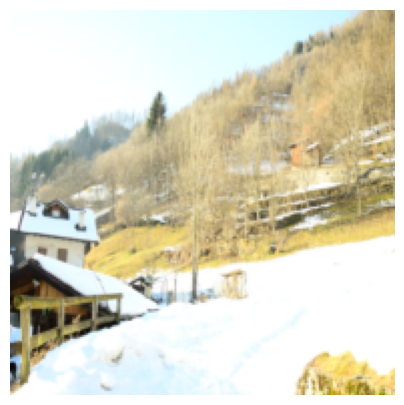

In [10]:
# Access the validation DataLoader
val_dl = dls.valid

# Get a batch of data from the validation set
batch = val_dl.one_batch()

# Decode the batch to make it interpretable (returning to original form like images and labels)
decoded_batch = val_dl.decode_batch(batch)

# Extract the first image (and optionally its label) from the decoded batch
img, label = decoded_batch[0]

# Show the image
img.show()
print('Label:', label)

Saves the paths of all validation images to the file val_file_paths.txt.

In [22]:
# Accessing file paths of the validation dataset
val_file_paths = dls.valid_ds.items

# Sort the list of paths
val_file_paths_sorted = sorted(val_file_paths)

# Path to the output text file
output_file_path = "val_file_paths.txt"

# Writing the sorted paths to the text file
with open(output_file_path, "w") as file:
    for path in val_file_paths_sorted:
        file.write(f"{path}\n")

Make a prediction for a single image

In [13]:
result, _, prob = learn.predict(img)
print(f'This Image is predicted as {result}. It\'s actual label is {label}.')
print(f'Probability: {prob[0]:4f}')

This Image is predicted as real. It's actual label is real.
Probability: 0.226576


## Saving the model
Saves the model as a pickle file.

In [8]:
learn.export(fname=models_path/f'export_run_{run}.pkl')

Imports the model again to check if it worked.

In [2]:
def custom_labeler(x):
    """Custom labeler to categorize images into 'fake' or 'real'."""
    # Convert the path to a string and check if 'fake' is part of the path
    if 'fake' in str(x):
        return 'fake'
    else:
        return 'real'
learn = load_learner('export.pkl')
learn.dls.vocab

['bird', 'forest']

## RISE Explanations

Imports

In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from explanations import RISE

Loads the model. It's very important to set requires_grad to False for all model parameters, since using RISE on a model while calculating gradients will cause extensive VRAM usage.

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = learn.model
model = model.eval()  # Set model to evaluation mode
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

# Initialize RISE with your model
# input_size = (224, 224)  # The input size used during training
input_size = (192, 192)  # For when using Resnet18
gpu_batch = 256  # Use maximum number that the GPU allows.
explainer = RISE(model, input_size, gpu_batch)

Generates the masks RISE uses. If the input size or one of the parameters changes they need to be regenerated, otherwise the masks file can just be loaded.

TODO: Right now the masks always need to generated since p1 isn't set when loading the mask from file.

In [5]:
# Parameters for mask generation
N = 6000
s = 8
p1 = 0.1

# Generate a filename based on parameters
filename = f'masks_N={N}_s={s}_p1={p1}_size={input_size[0]}x{input_size[1]}.npy'

# Generate or load masks
# Check if masks file exists with the specific configuration
if not os.path.isfile(filename):
    # If the file doesn't exist, generate new masks and save them
    explainer.generate_masks(N=N, s=s, p1=p1, savepath=filename)
    print(f'New masks generated and saved as {filename}')
else:
    # If the file exists, load the masks
    explainer.load_masks(filename)
    print(f'Masks loaded from {filename}.')

Generating filters: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1639.16it/s]


New masks generated and saved as masks_N=6000_s=8_p1=0.1_size=192x192.npy


Use RISE on an Input image and show the result.

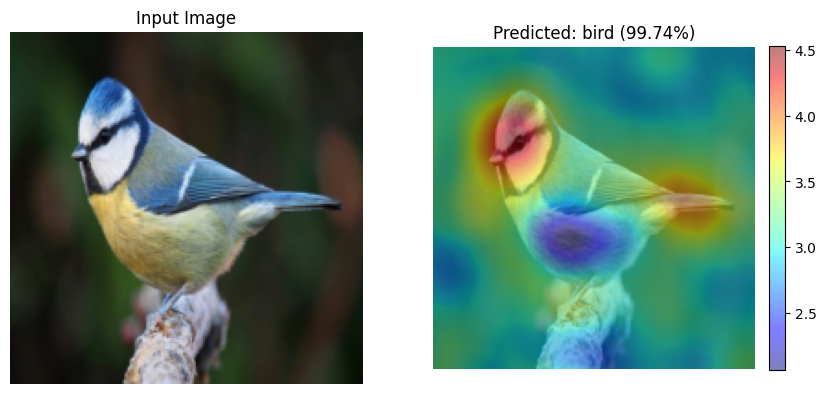

In [7]:
from torch.nn.functional import softmax

def show_rise(img_path):
    # Use DataLoader to process the image
    img = PILImage.create(img_path)
    data_loader = learn.dls.test_dl([img], bs=1)  # Create a test DataLoader
    img_tensor = data_loader.one_batch()[0].to(device)  # Retrieve the processed image as a tensor

    # Retrieve the processed image in a format that can be displayed
    img_processed = data_loader.show_batch(show=False)[0]
    img_processed = img_processed.squeeze(0)
    # Permute the tensor dimensions from (3, 224, 224) to (224, 224, 3)
    img_processed = img_processed.permute(1, 2, 0)
    
    saliency = explainer(img_tensor).cpu().numpy()  # Generate saliency map
    
    logits = model(img_tensor)  # Get model prediction
    pred_class = logits.argmax(dim=1).item()  # Predicted class index
    pred_class_name = learn.dls.vocab[pred_class] # Predicted class name
    probabilities = softmax(logits, dim=1)  # Convert logits to probabilities
    pred_prob = probabilities[0, pred_class].item() # Probability of the predicted class

    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'Input Image')
    plt.imshow(img_processed)  # Show the image
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title(f'Predicted: {pred_class_name} ({pred_prob:.2%})')
    plt.imshow(img_processed)  # Show the original image
    sal = saliency[pred_class]  # Get saliency map for the predicted class
    plt.imshow(sal, cmap='jet', alpha=0.5)  # Overlay the saliency map
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.show()

# Example usage
# show_rise('data/fake/dalle2/r00444b95t.png')
show_rise('bird_2.jpg')